In [14]:
# import required libraries
# read files
import os
# import torch and related libraries for machine learning
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
import pandas as pd # for data manipulation
from tqdm import tqdm # for iteration 
import matplotlib.pyplot as plt # visualization 
import optuna # type: ignore # optimization 
from sklearn.metrics import accuracy_score
from IPython.core.debugger import set_trace # for debugging

In [15]:
# set seed in torch
torch.manual_seed(235)

# If using CUDA, set seed to CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(235)
    torch.cuda.manual_seed_all(235)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.set_float32_matmul_precision('medium')    

In [16]:
# custom Dataset class - for  better accessibility
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__self(self, idx):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [17]:
from torchvision.datasets import MNIST
# read data
training_data = MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

# use 20% of training data for validation
train_set_size = int(len(training_data) * 0.8)
valid_set_size = len(training_data) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(training_data, [train_set_size, valid_set_size], generator=seed)

In [18]:
# initiate Dataloader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=1)
valid_dataloader = DataLoader(valid_set, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=1)

Image shape: torch.Size([28, 28]), Label: 2
Image shape: torch.Size([28, 28]), Label: 7
Image shape: torch.Size([28, 28]), Label: 6
Image shape: torch.Size([28, 28]), Label: 1
Image shape: torch.Size([28, 28]), Label: 7
Epoch 0:   7%|▋         | 70/938 [22:12<4:35:29,  0.05it/s, v_num=26, train_loss_step=1.750, train_acc_step=-0.754]


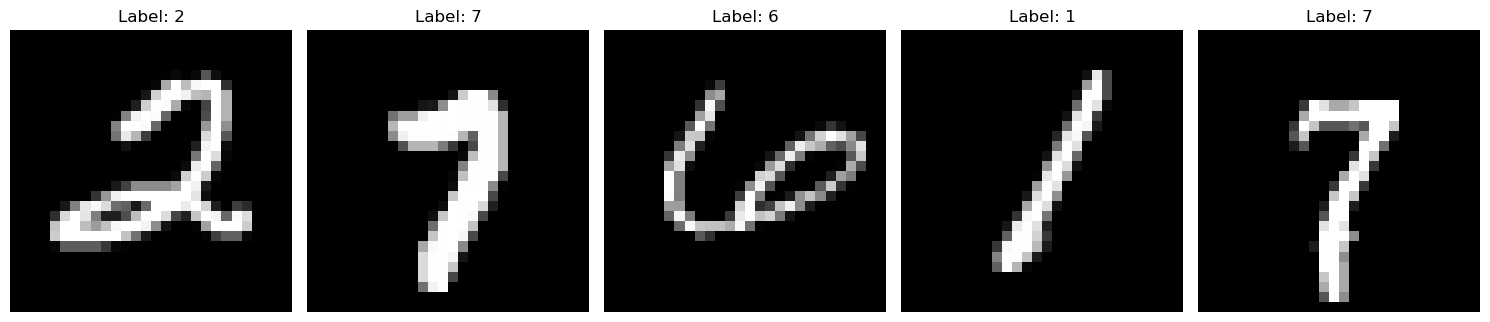

In [19]:
# View the data
plt.figure(figsize=(15, 5))  # Adjust figure size for better visibility

# Iterate through the dataset and print out images, dimensions, and labels
for i, (image, label) in enumerate(train_dataloader):
    if i < 5:
        print(f"Image shape: {image[0][0].shape}, Label: {label[0].item()}")  # Print image shape and label
        
        plt.subplot(1, 5, i + 1)  # Create a subplot
        plt.imshow(image[0].squeeze(), cmap='gray')  # Display the image
        plt.title(f"Label: {label[0].item()}", fontsize=12)  # Add the label as the title
        plt.axis('off')  # Hide axes for better visualization
    else:
        break
plt.tight_layout()
plt.show()


In [20]:
os.makedirs("mlp_trials", exist_ok=True)

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init=nn.init.xavier_uniform_, 
               loss_fn=nn.CrossEntropyLoss(), opt=torch.optim.Adam, lr=0.0001,
               weight_decay = 0.0, d = None, dropout_prob=None, 
               **kwargs
               ):
        # inherit from nn.Module (base class for all Modules)
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_init = weight_init
        self.loss_fn = loss_fn
        self.loss_list = list()
        self.dropout_prob = dropout_prob

        # initiate layers
        self.layers = nn.Sequential(
        nn.Flatten(),
        self.seq_block(self.input_dim, 64), 
        self.seq_block(64, 128), 
        self.seq_block(128, 256),
        self.seq_block(256, 128),
        self.seq_block(128, 64),
        nn.Linear(64, output_dim)
        )

        # initialize weights 
        self.apply(self.init_weights)

        # optimizer parameters
        self.lr = lr
        self.weight_decay = weight_decay
        self.opt = opt(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    # sequential block 
    def seq_block(self, input_dim_, output_dim_):
        seq_layers = nn.Sequential(
            nn.Linear(input_dim_, output_dim_),
            nn.ReLU(),
            nn.BatchNorm1d(output_dim_)
        )
        if self.dropout_prob:
            seq_layers.append(nn.Dropout(self.dropout_prob))
        return seq_layers
    
    # function to initialize weights
    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            self.weight_init(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.layers(x)

In [31]:
# use lighting for the training loop 
import lightning as L

class MLPWrapper(L.LightningModule):
    def __init__(self, model, lr=0.0001, weight_decay=0.0):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        inputs, target = batch
        predictions = self.model(inputs)
        loss = self.loss_fn(predictions, target)
        acc = (predictions.argmax(dim=1)==target).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        predictions = self.model(inputs)
        loss = self.loss_fn(predictions, target)
        acc= (predictions.argmax(dim=1)==target).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, target = batch
        predictions = self.model(inputs)
        loss = self.loss_fn(predictions, target)
        acc= (predictions.argmax(dim=1)==target).float().mean()
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def on_train_epoch_end(self):
        train_loss = self.trainer.logged_metrics.get("train_loss_epoch")
        print(f"Epoch {self.current_epoch + 1}: train_loss = {train_loss:.4f}")

In [32]:
# # train the model using lightning
# mlp = MLP(input_dim=28*28, output_dim=10)
# lightning_model=MLPWrapper(mlp)
# early_stoppping = L.pytorch.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=True)
# trainer = L.Trainer(max_epochs=20, accelerator="auto")
# trainer.fit(lightning_model, train_dataloader)

In [33]:
# function for optuna optimization
def objective(trial):
    # define parameters to optimize
    weight_decay = trial.suggest_float("weight_decay", 0.0001, 100)
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.5)

    mlp = mlp = MLP(input_dim=28*28, output_dim=10, lr=0.0001)
    lightning_model=MLPWrapper(mlp)
    early_stoppping = L.pytorch.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=True)
    trainer = L.Trainer(max_epochs=20, accelerator="auto")
    trainer.fit(lightning_model, train_dataloader, valid_dataloader)

    model_path = f"mlp_trials/mlp_trial_{trial.number}.pth"
    torch.save(mlp.state_dict(), model_path) # save model
    trial.set_user_attr("model_path", model_path) # set model path as user attribute
    
    return trainer.callback_metrics["val_acc"]

In [34]:
# Run Optuna optimization
# use grid search
search_space = { "weight_decay" : [1, 2, 5], "dropout_prob" : [0.2, 0.5] } 
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

# Print the best hyperparameters
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-12-26 09:48:43,399] A new study created in memory with name: no-name-5dbbc014-0639-442d-82cb-b4bc0b8ab2f7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
25        Modules in train mode
1         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\ml_win_old\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\User\anaconda3\envs\ml_win_old\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\User\anaconda3\envs\ml_win_old\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 56.09it/s, v_num=32, train_loss_step=0.0251, train_acc_step=1.000, val_loss=0.00472, val_acc=1.000, train_loss_epoch=0.0222, train_acc_epoch=0.993]  Epoch 20: train_loss = 0.0222


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 55.96it/s, v_num=32, train_loss_step=0.0251, train_acc_step=1.000, val_loss=0.00472, val_acc=1.000, train_loss_epoch=0.0222, train_acc_epoch=0.993]


[I 2024-12-26 09:54:22,546] Trial 0 finished with value: 0.9995833039283752 and parameters: {'weight_decay': 5.0, 'dropout_prob': 0.5}. Best is trial 0 with value: 0.9995833039283752.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
25        Modules in train mode
1         Modules in eval mode


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 55.57it/s, v_num=33, train_loss_step=0.0186, train_acc_step=1.000, val_loss=0.00639, val_acc=0.999, train_loss_epoch=0.0236, train_acc_epoch=0.993]  Epoch 20: train_loss = 0.0236


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 55.44it/s, v_num=33, train_loss_step=0.0186, train_acc_step=1.000, val_loss=0.00639, val_acc=0.999, train_loss_epoch=0.0236, train_acc_epoch=0.993]


[I 2024-12-26 10:00:00,403] Trial 1 finished with value: 0.9991666674613953 and parameters: {'weight_decay': 5.0, 'dropout_prob': 0.2}. Best is trial 0 with value: 0.9995833039283752.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
25        Modules in train mode
1         Modules in eval mode


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 57.62it/s, v_num=34, train_loss_step=0.0128, train_acc_step=1.000, val_loss=0.00608, val_acc=0.999, train_loss_epoch=0.022, train_acc_epoch=0.993]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20: train_loss = 0.0220
Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 57.49it/s, v_num=34, train_loss_step=0.0128, train_acc_step=1.000, val_loss=0.00608, val_acc=0.999, train_loss_epoch=0.022, train_acc_epoch=0.993]


[I 2024-12-26 10:05:31,731] Trial 2 finished with value: 0.9992499947547913 and parameters: {'weight_decay': 2.0, 'dropout_prob': 0.2}. Best is trial 0 with value: 0.9995833039283752.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
25        Modules in train mode
1         Modules in eval mode


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 55.72it/s, v_num=35, train_loss_step=0.00668, train_acc_step=1.000, val_loss=0.0109, val_acc=0.998, train_loss_epoch=0.0236, train_acc_epoch=0.992] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20: train_loss = 0.0236
Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 55.62it/s, v_num=35, train_loss_step=0.00668, train_acc_step=1.000, val_loss=0.0109, val_acc=0.998, train_loss_epoch=0.0236, train_acc_epoch=0.992]


[I 2024-12-26 10:11:05,726] Trial 3 finished with value: 0.9984166622161865 and parameters: {'weight_decay': 1.0, 'dropout_prob': 0.5}. Best is trial 0 with value: 0.9995833039283752.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
25        Modules in train mode
1         Modules in eval mode


Epoch 19: 100%|██████████| 938/938 [00:18<00:00, 50.50it/s, v_num=36, train_loss_step=0.0096, train_acc_step=1.000, val_loss=0.00554, val_acc=0.999, train_loss_epoch=0.0216, train_acc_epoch=0.994]  Epoch 20: train_loss = 0.0216


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 938/938 [00:18<00:00, 50.40it/s, v_num=36, train_loss_step=0.0096, train_acc_step=1.000, val_loss=0.00554, val_acc=0.999, train_loss_epoch=0.0216, train_acc_epoch=0.994]


[I 2024-12-26 10:16:43,272] Trial 4 finished with value: 0.9994166493415833 and parameters: {'weight_decay': 1.0, 'dropout_prob': 0.2}. Best is trial 0 with value: 0.9995833039283752.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
25        Modules in train mode
1         Modules in eval mode


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 56.08it/s, v_num=37, train_loss_step=0.104, train_acc_step=0.938, val_loss=0.00643, val_acc=0.999, train_loss_epoch=0.0224, train_acc_epoch=0.993]   Epoch 20: train_loss = 0.0224


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 55.95it/s, v_num=37, train_loss_step=0.104, train_acc_step=0.938, val_loss=0.00643, val_acc=0.999, train_loss_epoch=0.0224, train_acc_epoch=0.993]


[I 2024-12-26 10:22:18,987] Trial 5 finished with value: 0.9989166855812073 and parameters: {'weight_decay': 2.0, 'dropout_prob': 0.5}. Best is trial 0 with value: 0.9995833039283752.


Best trial:
  Value: 0.9995833039283752
  Params: 
    weight_decay: 5.0
    dropout_prob: 0.5
